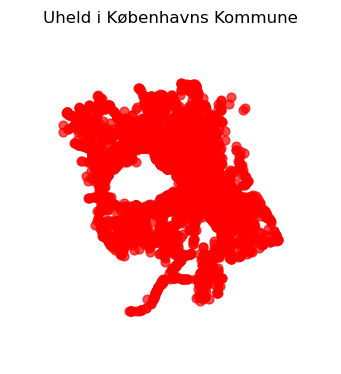

In [8]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# This was first attempt...

df = pd.read_csv('./data/2022-2024-accident-data.csv', sep=';', dtype=str, encoding='latin1')
df['X'] = df['X_KOORDINAT'].str.replace(',', '.').astype(float)
df['Y'] = df['Y_KOORDINAT'].str.replace(',', '.').astype(float)

# make GeoDataFrame
gdf = gpd.GeoDataFrame(df,
    geometry=gpd.points_from_xy(df['X'], df['Y']),
    crs='EPSG:25832')

fig, ax = plt.subplots(figsize=(4,4))
gdf.plot(ax=ax, marker='o', color='red', markersize=40, alpha=0.7)

minx, miny, maxx, maxy = gdf.total_bounds
margin = 3000
ax.set_xlim(minx - margin, maxx + margin)
ax.set_ylim(miny - margin, maxy + margin)

ax.set_title('Accidents in Københavns Kommune')
ax.set_axis_off()
plt.tight_layout()
plt.show()


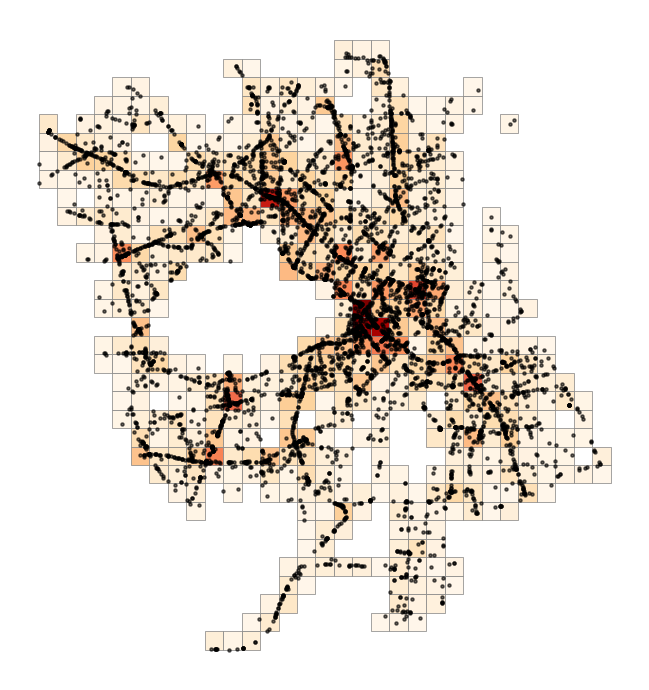

In [ ]:
# seconds attempt...

def count_accidents_grid(df, cell_size):
    """
    Given a DataFrame with float columns 'X' and 'Y' (in metres),
    returns a DataFrame of grid‐cell counts plus the origin (minx,miny).
    """
    # Drop na rows
    df2 = df[['X','Y']].copy().dropna()

    # Compute origin
    minx, miny = df2['X'].min(), df2['Y'].min()

    # Compute bin indices with floor
    df2['ix'] = np.floor((df2['X'] - minx) / cell_size).astype(int)
    df2['iy'] = np.floor((df2['Y'] - miny) / cell_size).astype(int)
    
    counts = (
        df2
        .groupby(['ix','iy'])
        .size()
        .reset_index(name='count')
    )
    
    # compute centres
    counts['center_x'] = minx + (counts['ix'] + 0.5) * cell_size
    counts['center_y'] = miny + (counts['iy'] + 0.5) * cell_size

    return counts, minx, miny

def plot_grid_counts(df, counts, minx, miny, cell_size):
    """
    Draws a coloured grid and overlays the accidents.
    """
    vmax = counts['count'].max()
    fig, ax = plt.subplots(figsize=(7,7))

    # draw each occupied cell
    for _, row in counts.iterrows():
        x0 = minx + row['ix'] * cell_size
        y0 = miny + row['iy'] * cell_size
        rect = plt.Rectangle(
            (x0, y0),
            cell_size, cell_size,
            facecolor=plt.cm.OrRd(row['count']/vmax),
            edgecolor='grey', linewidth=0.5
        )
        ax.add_patch(rect)

    # scatter points
    ax.scatter(df['X'], df['Y'], s=5, c='black', alpha=0.6)

    ax.set_aspect('equal')
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

cell_size = 400   # metres
grid, minx, miny = count_accidents_grid(df, cell_size)
plot_grid_counts(df, grid, minx, miny, cell_size)

In [35]:
grid.sort_values(by='count', ascending=False, inplace=True)

In [36]:
grid

,ix,iy,count,center_x,center_y
292,17,18,96,724066.001,6176113.565
291,17,17,91,724066.001,6175713.565
316,18,17,86,724466.001,6175713.565
178,12,24,77,722066.001,6178513.565
373,20,19,67,725266.001,6176513.565
...,...,...,...,...,...
117,8,28,1,720466.001,6180113.565
227,14,27,1,722866.001,6179713.565
383,20,29,1,725266.001,6180513.565
254,15,28,1,723266.001,6180113.565
